In [2]:
import numpy as np
from spec_id import Gen_sim, Scale_model
from scipy.interpolate import interp1d, interp2d
from astropy.cosmology import Planck13 as cosmo
from astropy.io import ascii
from astropy.table import Table
import rpy2
import rpy2.robjects as robjects
R = robjects.r
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [3]:
print 'done'

done


In [4]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [6]:
spec = Gen_sim(galDB['gids'][220],galDB['hi_res_specz'][220],0.019,3.5,8.0)

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


In [7]:
spec.Perturb_flux()
spec.Sim_spec(0.005,2.0,0)

In [15]:
wv = robjects.FloatVector(spec.gal_wv_rf)
fl = robjects.FloatVector(spec.flx_err)

df = robjects.DataFrame({'wv':wv,'fl':fl})

In [9]:
df

R object with classes: ('data.frame',) mapped to:
<DataFrame - Python:0x120ae9ea8 / R:0x7ff4fdccc150>
[FloatVector, FloatVector]
  wv: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x128a114d0 / R:0x7ff4fe5ce600>
[3911.187428, 3917.284879, 3923.382330, ..., 5575.791674, 5581.889126, 5587.986577]
  fl: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x128a11998 / R:0x7ff4fe48ba00>
[2.766850, 2.634876, 2.026510, ..., 4.718108, 4.408454, 4.677307]

In [16]:
smth_flux = R.loess('fl~wv',data = df)

In [20]:
R.plot(df[0],df[1],pch=20, cex=0.5,xlab='wv', ylab='fl')
R.lines(df[0], R.predict(smth_flux), lwd=2, col=2)

rpy2.rinterface.NULL

In [17]:
cont = np.array(R.predict(smth_flux))

In [26]:
IDfe1 = []
IDfe2 = []
IDfe3 = []
IDca = []
IDhd = []
IDg = []
IDhb = []
IDmgb = []

IDf =[]
for i in range(len(spec.gal_wv_rf)):
    if 3800 <= spec.gal_wv_rf[i] <= 3850:
        IDfe1.append(i)
    if 3910 <= spec.gal_wv_rf[i] <= 4030:
        IDca.append(i)
    if 4080 <= spec.gal_wv_rf[i] <= 4125:
        IDhd.append(i)
    if 4250 <= spec.gal_wv_rf[i] <= 4385:
        IDg.append(i)
    if 4515 <= spec.gal_wv_rf[i] <= 4570:
        IDfe2.append(i)
    if 4810 <= spec.gal_wv_rf[i] <= 4910:
        IDhb.append(i)
    if 4975 <= spec.gal_wv_rf[i] <= 5055:
        IDfe3.append(i)
    if 5110 <= spec.gal_wv_rf[i] <= 5285:
        IDmgb.append(i)

IDF=np.array([IDfe1, IDca, IDhd, IDg, IDfe2, IDhb, IDfe3, IDmgb])

IDf = []
for i in range(len(spec.gal_wv_rf)):
    if 3800 <= spec.gal_wv_rf[i] <= 3850 or 3910 <= spec.gal_wv_rf[i] <= 4030 or 4080 <= spec.gal_wv_rf[i] <= 4125 \
            or 4250 <= spec.gal_wv_rf[i] <= 4385 or 4515 <= spec.gal_wv_rf[i] <= 4570 or 4810 <= spec.gal_wv_rf[i]\
            <= 4910 or 4975 <= spec.gal_wv_rf[i] <= 5055 or 5110 <= spec.gal_wv_rf[i] <= 5285:
        IDf.append(i)

In [19]:
def smoothing(fl,h):
    kernal=-np.linspace(-1,1,h+3)**2+1

    sm = np.zeros(len(fl))
    for i in range(len(fl)):
        w = np.zeros(len(fl))
        for ii in range(len(kernal)):
            if ii + i - h + 1 >= 0 and ii + i - h + 1 < len(fl):
                w[ii + i - h + 1] = kernal[ii] 
        sm[i] = sum(fl[w != 0] * w[w != 0]) / sum(w[w != 0])
    return sm

In [38]:
Fmfl = np.array([])
for i in range(len(IDF)):
    C = Scale_model(spec.flx_err[IDF[i]],spec.gal_er[IDF[i]],spec.mfl[IDF[i]])
    Fmfl = np.append(Fmfl,C*spec.mfl[IDF[i]])

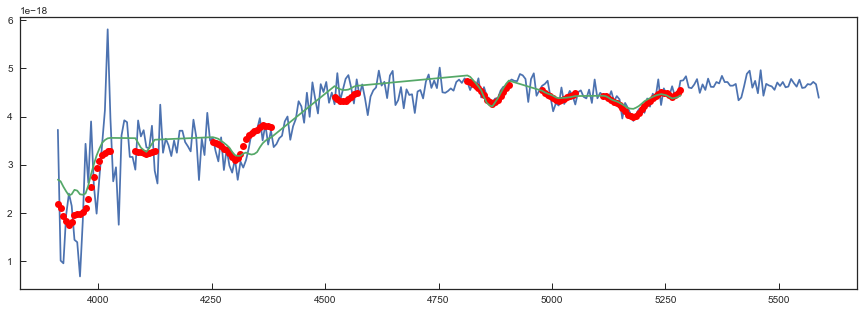

In [40]:
plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.flx_err)
plt.plot(spec.gal_wv_rf[IDf],spec.fl[IDf],'ro')
plt.plot(spec.gal_wv_rf[IDf],Fmfl)
plt.show()
plt.close()

In [23]:
smflxer = smoothing(spec.flx_err,50)
smfl = smoothing(spec.fl,50)

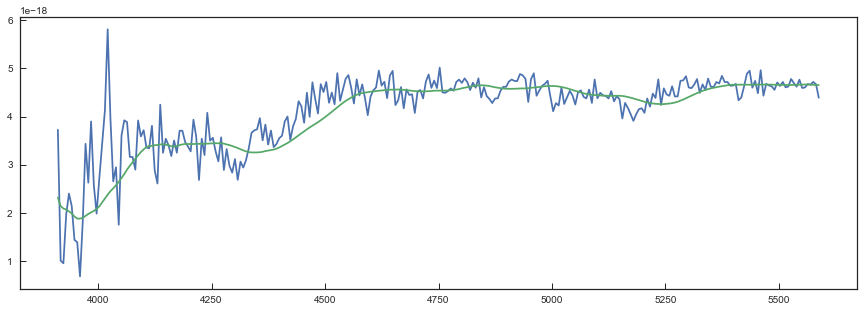

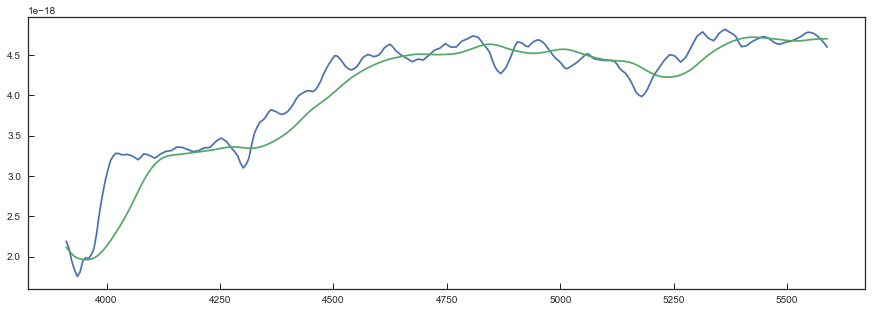

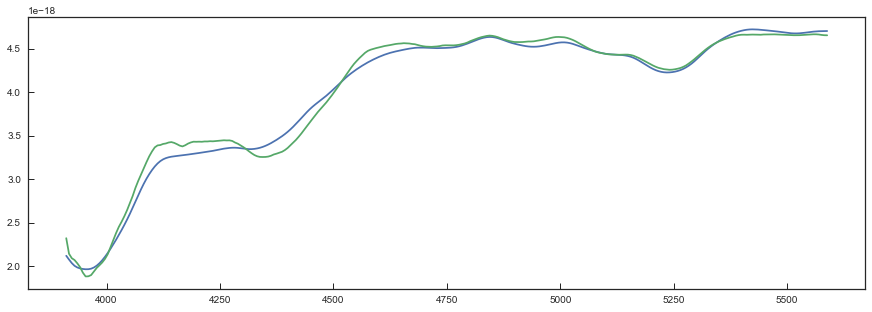

In [ ]:
plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.flx_err)
plt.plot(spec.gal_wv_rf,smflxer)
plt.show()
plt.close()

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.fl)
plt.plot(spec.gal_wv_rf,smfl)
plt.show()
plt.close()

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,smfl)
plt.plot(spec.gal_wv_rf,smflxer)
plt.show()
plt.close()

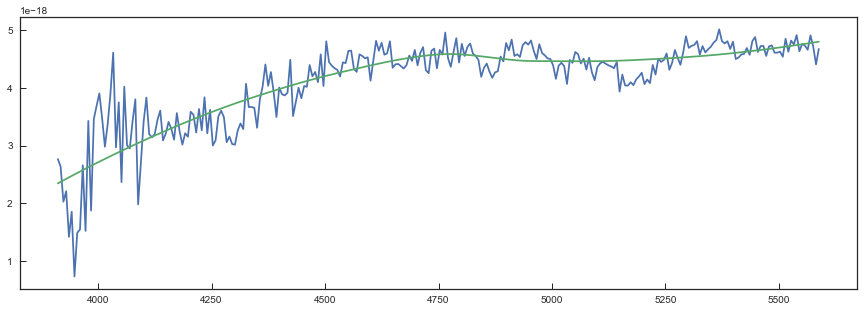

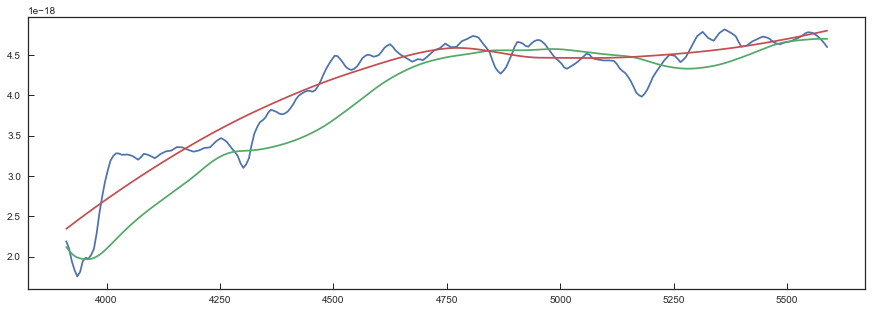

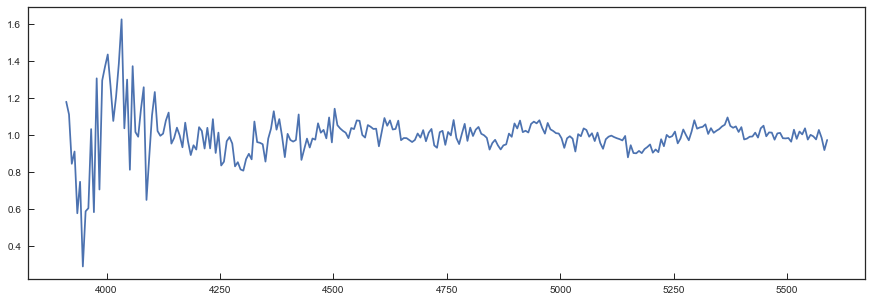

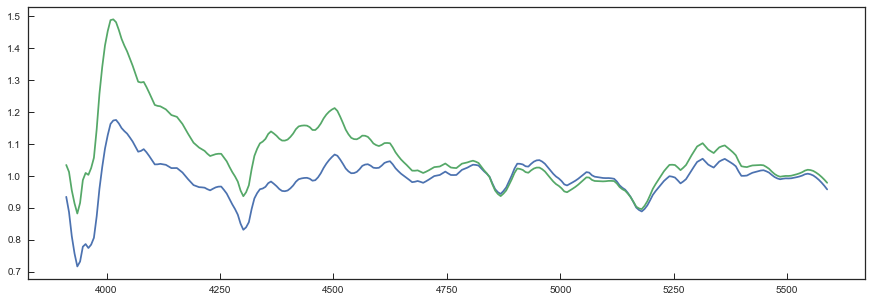

In [25]:
%matplotlib inline

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.flx_err)
plt.plot(spec.gal_wv_rf,cont)
plt.show()
plt.close()

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.fl)
plt.plot(spec.gal_wv_rf,smfl)
plt.plot(spec.gal_wv_rf,cont)
plt.show()
plt.close()

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.flx_err/cont)
plt.show()
plt.close()

plt.figure(figsize=[15,5])
plt.plot(spec.gal_wv_rf,spec.fl/cont)
plt.plot(spec.gal_wv_rf,spec.fl/smfl)
plt.show()
plt.close()